# **Impacto da Probabilidade de Crossover versus Pressão de Seleção**

Em problemas deceptivos, como o $\text{trap}_k$, cada bloco possui um ótimo local que pode atrair a busca, enquanto o ótimo global é mais difícil de ser alcançado devido às armadilhas construídas para desviar o processo evolutivo.

Dois parâmetros críticos controlam esse processo:  
  1. **Probabilidade de crossover** $p_c$, que determina a frequência de troca de material genético entre pais.  
  2. **Pressão de seleção**, intensidade com que o processo de seleção favorece indivíduos de maior fitness.

Os **Building-Blocks (BBs)** ótimos (blocos com $r=k$) devem emergir e recombinar para escapar da região de armadilha.  

## 1. Análise com Torneio

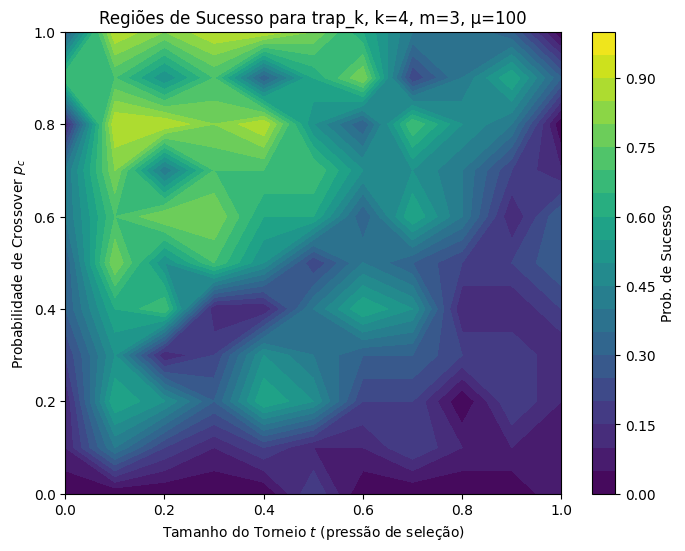

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def trap_k_fitness(x, k):
    m = len(x) // k
    total = 0
    for j in range(m):
        block = x[j*k:(j+1)*k]
        r = np.sum(block)
        total += (k if r == k else (k - 1 - r))
    return total

def initialize_population(mu, n):
    return np.random.randint(0, 2, size=(mu, n))

def tournament_selection(pop, fitnesses, t):
    mu = pop.shape[0]
    selected = []
    for _ in range(mu):
        participants = np.random.choice(mu, size=t, replace=False)
        best = participants[np.argmax(fitnesses[participants])]
        selected.append(pop[best].copy())
    return np.array(selected)

def one_point_crossover(parent1, parent2, p_c):
    n = parent1.size
    if np.random.rand() < p_c:
        c = np.random.randint(1, n)
        child1 = np.concatenate([parent1[:c], parent2[c:]])
        child2 = np.concatenate([parent2[:c], parent1[c:]])
        return child1, child2
    return parent1.copy(), parent2.copy()

def run_ga(n, k, mu, p_c, t, max_gen):
    pop = initialize_population(mu, n)
    target = (n//k) * k
    for gen in range(max_gen):
        fitnesses = np.array([trap_k_fitness(ind, k) for ind in pop])
        if np.any(fitnesses == target):
            return True
        # selection
        parents = tournament_selection(pop, fitnesses, int(t * mu) if t > 0 else 1)
        # crossover
        children = []
        for i in range(0, mu, 2):
            p1, p2 = parents[i], parents[(i+1)%mu]
            c1, c2 = one_point_crossover(p1, p2, p_c)
            children.append(c1)
            children.append(c2)
        pop = np.array(children[:mu])
    return False

# Experiment grid
m = 3
k = 4
n = m * k
mus = 100
max_gen = 100
t_values = np.linspace(0, 1, 11) 
p_c_values = np.linspace(0, 1, 11)

# Matriz de probabilidade de sucesso
P = np.zeros((len(t_values), len(p_c_values)))

trials = 10

for i, t in enumerate(t_values):
    for j, p_c in enumerate(p_c_values):
        successes = 0
        for _ in range(trials):
            if run_ga(n, k, mus, p_c, t, max_gen):
                successes += 1
        P[i, j] = successes / trials

# Plotagem
T, PC = np.meshgrid(t_values, p_c_values, indexing='ij')
plt.figure(figsize=(8,6))
cp = plt.contourf(T, PC, P, levels=np.linspace(0,1,21), cmap='viridis')
plt.colorbar(cp, label='Prob. de Sucesso')
plt.ylabel('Probabilidade de Crossover $p_c$')
plt.xlabel('Tamanho do Torneio $t$ (pressão de seleção)')
plt.title(f'Regiões de Sucesso para trap_k, k={k}, m={m}, μ={mus}')
plt.show()


## 2. Análise com seleção dos melhores

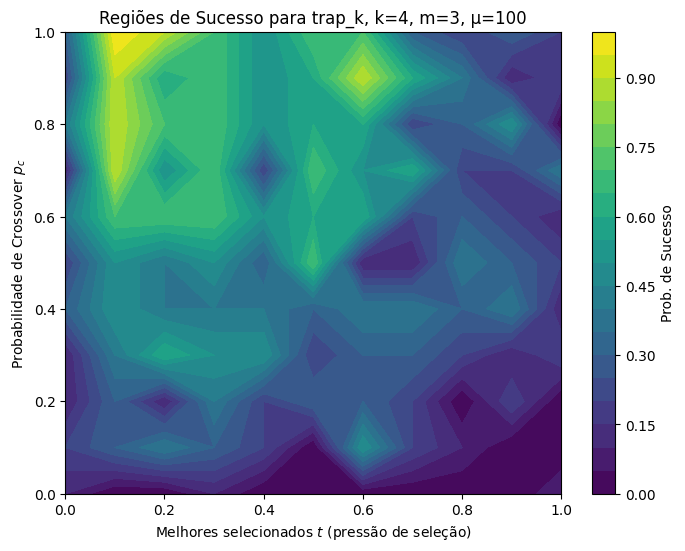

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def trap_k_fitness(x, k):
    """Compute trap_k fitness for an individual x segmented in blocks of size k."""
    m = len(x) // k
    total = 0
    for j in range(m):
        block = x[j*k:(j+1)*k]
        r = np.sum(block)
        total += (k if r == k else (k - 1 - r))
    return total

def initialize_population(mu, n):
    return np.random.randint(0, 2, size=(mu, n))

def best_selection(pop, fitnesses, t):
    """Seleciona os t melhores indivíduos da população."""
    best_indices = np.argsort(fitnesses)[-t:][::-1]  # Índices dos t melhores, do maior para o menor fitness
    selected = pop[best_indices]
    return selected

def one_point_crossover(parent1, parent2, p_c):
    n = parent1.size
    if np.random.rand() < p_c:
        c = np.random.randint(1, n)
        child1 = np.concatenate([parent1[:c], parent2[c:]])
        child2 = np.concatenate([parent2[:c], parent1[c:]])
        return child1, child2
    return parent1.copy(), parent2.copy()

def run_ga(n, k, mu, p_c, t, max_gen):
    pop = initialize_population(mu, n)
    target = (n//k) * k
    for gen in range(max_gen):
        fitnesses = np.array([trap_k_fitness(ind, k) for ind in pop])
        if np.any(fitnesses == target):
            return True
        # selection
        parents = tournament_selection(pop, fitnesses, int(t * mu) if t > 0 else 1)
        # crossover
        children = []
        for i in range(0, mu, 2):
            p1, p2 = parents[i], parents[(i+1)%mu]
            c1, c2 = one_point_crossover(p1, p2, p_c)
            children.append(c1)
            children.append(c2)
        pop = np.array(children[:mu])
    return False

# Experiment grid
m = 3
k = 4
n = m * k
mus = 100
max_gen = 100
t_values = np.linspace(0, 1, 11) 
p_c_values = np.linspace(0, 1, 11)

# success probability matrix
P = np.zeros((len(t_values), len(p_c_values)))

trials = 10

for i, t in enumerate(t_values):
    for j, p_c in enumerate(p_c_values):
        successes = 0
        for _ in range(trials):
            if run_ga(n, k, mus, p_c, t, max_gen):
                successes += 1
        P[i, j] = successes / trials

# Plot contour
T, PC = np.meshgrid(t_values, p_c_values, indexing='ij')
plt.figure(figsize=(8,6))
cp = plt.contourf(T, PC, P, levels=np.linspace(0,1,21), cmap='viridis')
plt.colorbar(cp, label='Prob. de Sucesso')
plt.ylabel('Probabilidade de Crossover $p_c$')
plt.xlabel('Melhores selecionados $t$ (pressão de seleção)')
plt.title(f'Regiões de Sucesso para trap_k, k={k}, m={m}, μ={mus}')
plt.show()

Em ambos os casos podemos observar o comportamente esperado:

![Captura de tela 2025-04-26 193934.png](<attachment:Captura de tela 2025-04-26 193934.png>)
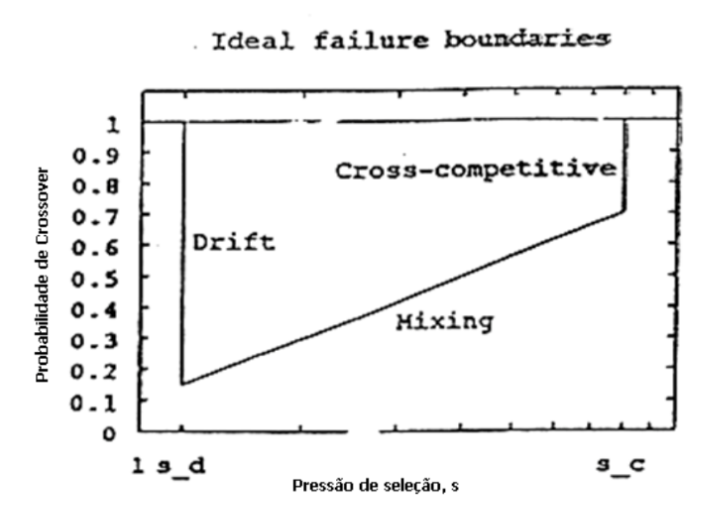